In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import os
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, r2_score
import sklearn
import copy
from icecream import ic
import time

from utils import *

plt.style.use('seaborn')

/tmp/ipykernel_209298/150901031.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [27]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

class DecisionTree:
    def __init__(self,
                 criterion,
                 max_depth,
                 task):
        self.criterion = criterion
        self.max_depth = max_depth
        self.task = task
        self.model = DecisionTreeClassifier(criterion=self.criterion, max_depth=self.max_depth)  if task == 'classification' \
                    else DecisionTreeRegressor(criterion=self.criterion, max_depth=self.max_depth)
        
    def __call__(self, x):
        pred = self.model.predict(x) 
        return np.expand_dims(pred, -1) if self.task == 'regression' else pred
        
    def train(self, X, y):
        self.model.fit(X, y)
        print("Accuracy of decision tree:", self.model.score(X, y))
        

In [28]:
from collections import Counter

class Bagging:
    def __init__(self, 
                 model_list, 
                 X, y,
                 num_estimators, 
                 frac:float, 
                 bootstrap:bool, 
                 voting_mechanism:str,
                 task:str) -> None:
        
        self.model_list = model_list
        self.num_estimators = num_estimators
        self.frac = frac
        self.bootstrap = bootstrap
        self.voting_mechanism = voting_mechanism
        self.task = task
        self.X, self.y = X, y
        self.num_samples = len(self.X)
        self.model_list = [copy.deepcopy(model) for model in self.model_list for _ in range(self.num_estimators)]
        self.model_weights = None
        
    def hard_vote(self, preds):
        if self.task == 'classification':
            preds = np.array([np.argmax(i, axis=-1).tolist() for i in preds])
            return [Counter(i).most_common(1)[0][0] for i in preds.T]
        else:
            return np.mean(preds, axis=0)
        
    def soft_vote(self, preds):
        if self.task == 'classification':
            preds = np.array(preds) * self.model_weights[:, None, None]
            preds = np.sum(preds, axis=0)
            return np.argmax(preds, axis=-1)
        else:
            preds = np.array(preds) * self.model_weights[:, None, None]
            return np.sum(preds, axis=0)
              
    def __call__(self, x):
        self.preds = []
        for model in self.model_list:
            self.preds.append(model(x))
            
        if self.voting_mechanism == 'hard':
            return self.hard_vote(self.preds)
        else:
            print("Prediction using soft vote")
            return self.soft_vote(self.preds)
    
    def validate(self, x, y):
        self.preds = [model(x) for model in self.model_list]
        if self.task == 'classification':
            acc = np.array([accuracy_score(np.argmax(y, -1), np.argmax(pred, -1)) for pred in self.preds])
            return acc/np.sum(acc)
        else:
            losses = np.array([MSELoss()(y, pred) for pred in self.preds])
            losses = 1/losses
            return losses/np.sum(losses)
        
    def get_training_data(self, i):
        if self.bootstrap:
            indices = np.random.randint(0, self.num_estimators, int(self.frac * self.num_samples))
            return self.X[indices], self.y[indices]
        else:
            start, end = i * int((self.num_samples)/self.num_estimators), (i + 1) * (int((self.num_samples)/self.num_estimators))
            return self.X[start:end, :], self.y[start:end, ]
    
    def train(self):
        self.time_taken = time.time()
        
        for model in self.model_list:
            indices = np.random.randint(0, self.num_samples, int(self.frac * self.num_samples))
            model.train(self.X[indices], self.y[indices])
            
        print("Training done!")

        if self.voting_mechanism == 'soft':
            self.model_weights = self.validate(self.X, self.y)
            print("Model weights loaded")
            
        self.time_taken = time.time() - self.time_taken

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv('./data/WineQT.csv').drop(columns=['Id'], axis=0)

scaler = StandardScaler()

df['quality'] = df['quality'].map(lambda x : x - 3)
df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])

df_train, df_val = train_test_split(df, test_size=0.2)

X_train_c, y_train_c = df_train.values[:, :-1], pd.get_dummies(df_train.values[:, -1], dtype=np.float32).values
X_val_c, y_val_c = df_val.values[:, :-1], pd.get_dummies(df_val.values[:, -1], dtype=np.float32).values

X_train_c.shape, X_val_c.shape, y_train_c.shape, y_val_c.shape

((914, 11), (229, 11), (914, 6), (229, 6))

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv('./data/HousingData.csv')
nan_cols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'AGE', 'LSTAT']
for col in nan_cols:
    df[col] = df[col].fillna(df[col].mean(), inplace=False)
    

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled_data, columns=df.columns)


X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(df_scaled.iloc[:, :-1].values, df_scaled.iloc[:, -1].values, test_size=0.1)
y_train_r, y_val_r = y_train_r.reshape(-1, 1), y_val_r.reshape(-1, 1)

X_train_r.shape, y_train_r.shape, X_val_r.shape, y_val_r.shape


((455, 13), (455, 1), (51, 13), (51, 1))

In [126]:

logistic = Model(lr=1e-3, logger=None, loss_fxn=CrossEntropyLoss(), type='classification', epochs=1000)
logistic.add(Layer(11, 6, Softmax()))

mlp = Model(lr=1e-3, logger=None, loss_fxn=CrossEntropyLoss(), type='classification', epochs=1000)
mlp.add(Layer(11, 16, activation=Sigmoid()))
mlp.add(Layer(16, 16, Sigmoid()))
mlp.add(Layer(16, 6, Softmax()))

dt = DecisionTree(criterion='gini', max_depth=5, task='classification')


In [85]:
bag = Bagging(
    model_list=[logistic, mlp, dt],
    X=X_train_c,
    y=y_train_c,
    frac=0.50,
    num_estimators=3,
    bootstrap=True,
    voting_mechanism='hard',
    task='classification'
)

bag

In [8]:
bag.train()

epoch: 999 	Train:[loss:3.1133 acc:0.1575]]
epoch: 999 	Train:[loss:3.2298 acc:0.1269]]
epoch: 999 	Train:[loss:3.1128 acc:0.1554]]
epoch: 999 	Train:[loss:1.6280 acc:0.3414]]
epoch: 999 	Train:[loss:1.7977 acc:0.3786]]
epoch: 999 	Train:[loss:1.7930 acc:0.3742]]
Accuracy of decision tree: 0.7724288840262582
Accuracy of decision tree: 0.7199124726477024
Accuracy of decision tree: 0.7592997811816192
Training done!


In [9]:
pred = bag(X_train_c)
accuracy_score(np.argmax(y_train_c, -1), pred)

0.3588621444201313

### 3.2.2

In [105]:
def find_best_model(X_train, y_train, X_val, y_val, task, transform_y, accuracy_fxn):
    
    df = {
        'num_estimator' : [],
        'frac': [],
        'voting': [],
        'train_acc': [], 'val_acc': [],
        'model':[], 'bootstrap': []
    }
    
    for num_estimator in tqdm([1, 3, 5, 8]):
        for frac in [0.15, 0.25, 0.50]:
            for voting in ['hard', 'soft']:
                for bootstrap in [True, False]:
                    for model in [linear, mlp, dt]:
                        bag = Bagging(
                            model_list=[model],
                            X=X_train,
                            y=y_train,
                            frac=frac,
                            num_estimators=num_estimator,
                            bootstrap=bootstrap,
                            voting_mechanism=voting,
                            task=task
                        )
                        
                        bag.train()
                        
                        df['train_acc'].append(accuracy_fxn(transform_y(y_train, -1), bag(X_train)))
                        df['val_acc'].append(accuracy_fxn(transform_y(y_val, -1), bag(X_val)))
                        df['num_estimator'].append(num_estimator)
                        df['frac'].append(frac)
                        df['voting'].append(voting)
                        df['model'].append(model)
                        df['bootstrap'].append(bootstrap)
                        
                    
    df = pd.DataFrame(df)
    df.to_csv(f'./bagging_all_combinations_{task}.csv', index=False)
    return df

In [106]:
# df_classification = find_best_model(X_train_c, y_train_c, X_val_c, y_val_c, task='classification', transform_y=np.argmax, accuracy_fxn=accuracy_score)
# df_regression = find_best_model(X_train_r, y_train_r, X_val_r, y_val_r, task='regression', transform_y=lambda x, y: x, accuracy_fxn=r2_score)

  0%|          | 0/4 [00:00<?, ?it/s]

epoch: 1999 	Train:[loss:0.2481 acc:0.7496]]
Training done!
epoch: 999 	Train:[loss:0.1495 acc:0.7519]]
Training done!
Accuracy of decision tree: 0.9851054545621243
Training done!
epoch: 1999 	Train:[loss:0.2023 acc:0.8045]]
Training done!
epoch: 999 	Train:[loss:0.0402 acc:0.9447]]
Training done!
Accuracy of decision tree: 0.9792260610713047
Training done!
epoch: 1999 	Train:[loss:0.3606 acc:0.7372]]
Training done!
Model weights loaded
Prediction using soft vote
Prediction using soft vote
epoch: 999 	Train:[loss:0.1865 acc:0.8604]]
Training done!
Model weights loaded
Prediction using soft vote
Prediction using soft vote
Accuracy of decision tree: 0.9825464851665007
Training done!
Model weights loaded
Prediction using soft vote
Prediction using soft vote
epoch: 1999 	Train:[loss:0.2764 acc:0.7697]]
Training done!
Model weights loaded
Prediction using soft vote
Prediction using soft vote
epoch: 999 	Train:[loss:0.0444 acc:0.9583]]
Training done!
Model weights loaded
Prediction using sof

In [103]:
df_classification = pd.read_csv('./bagging_all_combinations_classification.csv').sort_values(by='val_acc', ascending=False)
df_classification

,num_estimator,frac,voting,train_acc,val_acc,model,bootstrap
104,5,0.50,soft,0.700219,0.602620,<__main__.DecisionTree object at 0x7f950c8cc9a0>,True
95,5,0.25,soft,0.654267,0.602620,<__main__.DecisionTree object at 0x7f950c8cc9a0>,False
131,8,0.25,soft,0.677243,0.598253,<__main__.DecisionTree object at 0x7f950c8cc9a0>,False
107,5,0.50,soft,0.684902,0.589520,<__main__.DecisionTree object at 0x7f950c8cc9a0>,False
128,8,0.25,soft,0.679431,0.589520,<__main__.DecisionTree object at 0x7f950c8cc9a0>,True
...,...,...,...,...,...,...,...
51,3,0.25,hard,0.161926,0.205240,Layer: [in:11] [out:6] [activation:Softmax]\n,False
45,3,0.15,soft,0.165208,0.200873,Layer: [in:11] [out:6] [activation:Softmax]\n,False
15,1,0.25,hard,0.160832,0.200873,Layer: [in:11] [out:6] [activation:Softmax]\n,False
3,1,0.15,hard,0.165208,0.196507,Layer: [in:11] [out:6] [activation:Softmax]\n,False


In [107]:
df_regression = pd.read_csv('./bagging_all_combinations_regression.csv').sort_values(by='val_acc', ascending=False)
df_regression

,num_estimator,frac,voting,train_acc,val_acc,model,bootstrap
125,8,0.25,hard,0.840468,0.821622,<__main__.DecisionTree object at 0x7f950cae8520>,False
128,8,0.25,soft,0.842303,0.813753,<__main__.DecisionTree object at 0x7f950cae8520>,True
116,8,0.15,soft,0.824343,0.800956,<__main__.DecisionTree object at 0x7f950cae8520>,True
92,5,0.25,soft,0.841089,0.800267,<__main__.DecisionTree object at 0x7f950cae8520>,True
122,8,0.25,hard,0.849182,0.799214,<__main__.DecisionTree object at 0x7f950cae8520>,True
...,...,...,...,...,...,...,...
4,1,0.15,hard,-0.179765,-0.883337,Layer: [in:13] [out:16] [activation:Tanh]\nLay...,False
109,8,0.15,hard,0.058083,-1.015930,Layer: [in:13] [out:16] [activation:Tanh]\nLay...,True
43,3,0.15,soft,-0.247863,-1.104357,Layer: [in:13] [out:16] [activation:Tanh]\nLay...,True
7,1,0.15,soft,-0.529045,-1.383477,Layer: [in:13] [out:16] [activation:Tanh]\nLay...,True


### 3.2.3

In [78]:
def create_heatmap(X, y, task):
    acc = {}
    
    # y_labels = np.argmax(y, axis=-1)
    for model in tqdm([linear, mlp, dt]):
        acc[model] = []
        for frac in tqdm([0.15, 0.25, 0.5]):
            temp = []
            for num_estimators in tqdm([1, 2, 3, 4]):
                bag = Bagging(
                    model_list=[model],
                    X=X,
                    y=y,
                    frac=frac,
                    num_estimators=num_estimators,
                    bootstrap=False,
                    voting_mechanism='hard',
                    task=task
                )
                bag.train()
                pred = np.array(bag(X))
                # print(pred)
                temp.append(r2_score(y, pred))
                
            acc[model].append(temp)

    return acc
            

In [81]:
# heatmap_classification = create_heatmap(X_train_c, y_train_c, task='classification')
# heatmap_regression = create_heatmap(X_train_r, y_train_r, task='regression')            


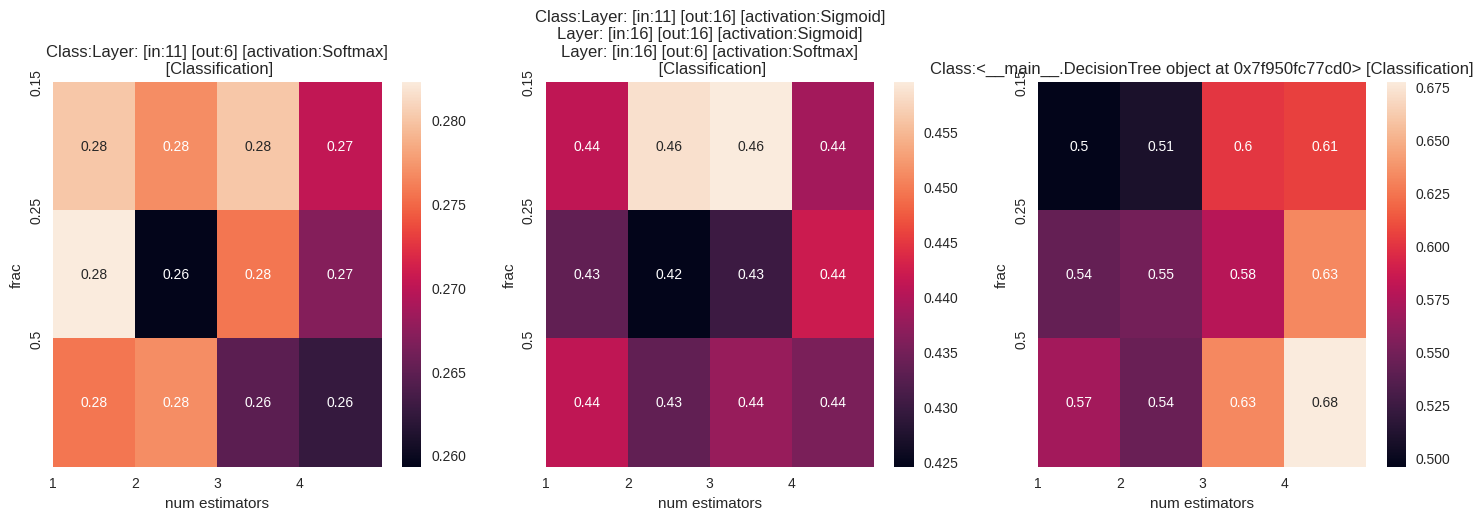

In [61]:
plt.figure(figsize=(18, 5))

for i, (k, v) in enumerate(heatmap_classification.items()):
    plt.subplot(1, 3, i + 1)
    
    sea.heatmap(data=v, annot=True)
    plt.ylabel('frac')
    plt.xlabel('num estimators')
    plt.yticks(np.arange(3), [0.15, 0.25, 0.5])
    plt.xticks(np.arange(4), [1, 2, 3, 4])
    plt.title(f'Class:{k} [Classification]')

plt.show()

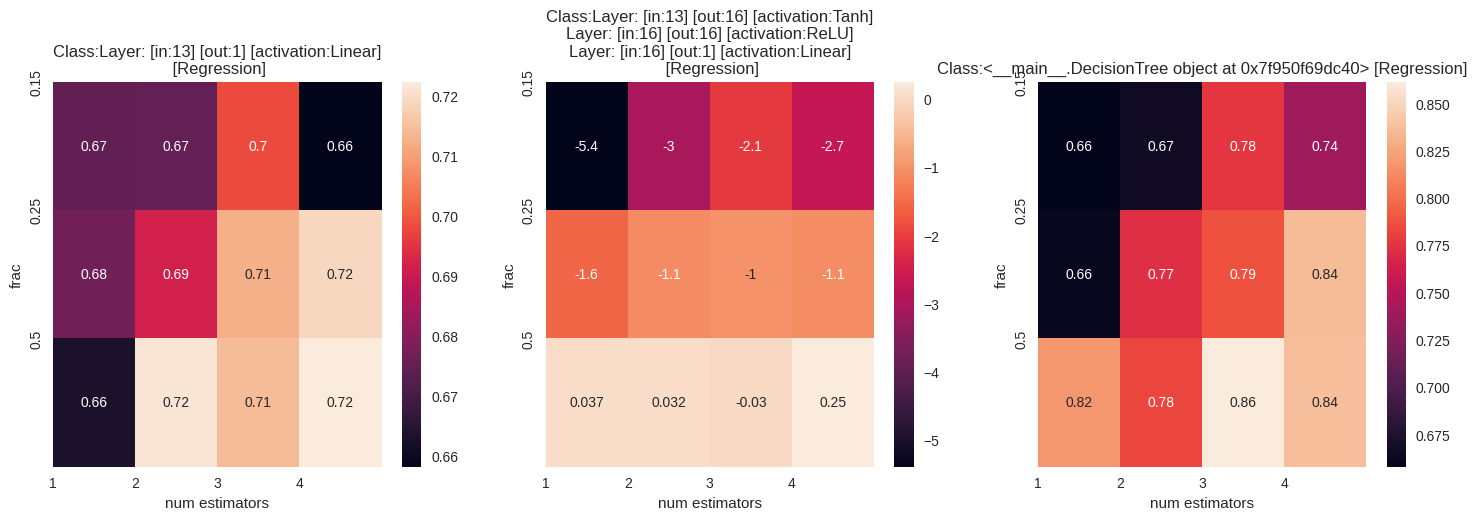

In [80]:
plt.figure(figsize=(18, 5))

for i, (k, v) in enumerate(heatmap_regression.items()):
    plt.subplot(1,3,i + 1)
    sea.heatmap(data=v, annot=True)
    plt.ylabel('frac')
    plt.xlabel('num estimators')
    plt.yticks(np.arange(3), [0.15, 0.25, 0.5])
    plt.xticks(np.arange(4), [1, 2, 3, 4])
    plt.title(f'Class:{k} [Regression]')

plt.show()

### 3.2.4

In [118]:
def get_best_models(df):
    max_indices = df.groupby('model')['val_acc'].idxmax()
    return df.loc[max_indices]


best_classifiers = get_best_models(df_classification)
best_regressors = get_best_models(df_regression)

In [119]:
best_classifiers

,num_estimator,frac,voting,train_acc,val_acc,model,bootstrap
104,5,0.50,soft,0.700219,0.602620,<__main__.DecisionTree object at 0x7f950c8cc9a0>,True
22,1,0.25,soft,0.420131,0.401747,Layer: [in:11] [out:16] [activation:Sigmoid]\n...,False
18,1,0.25,soft,0.165208,0.222707,Layer: [in:11] [out:6] [activation:Softmax]\n,True


In [124]:
def compare_models(list_1, df, X_train, y_train, X_val, y_val, accuracy_fxn, y_transform, name, list_1_names, bagging_accs):
    list_1_accs = []
    for model in list_1:
        model.train(X_train, y_train)
        pred = model(X_val)
        list_1_accs.append(accuracy_fxn(y_transform(y_val, -1), y_transform(pred, -1)))

    data = {
        'Category': list_1_names * 2,
        'Value': bagging_accs + list_1_accs,
        'Type': ['bagging', 'bagging', 'bagging', 'non-bagging', 'non-bagging', 'non-bagging']
    }
    
    # print(data)
    df_t = pd.DataFrame(data)

    plt.figure(figsize=(8, 6))
    sea.barplot(x='Category', y='Value', hue='Type', data=df_t)
    
    plt.xlabel('Models')
    plt.ylabel('Accuracies')
    plt.title(f'Ensemble vs Vanilla: {name}')
    
    

Accuracy of decision tree: 0.5645514223194749
epoch: 999 	Train:[loss:1.2618 acc:0.4923]]
epoch: 999 	Train:[loss:4.1823 acc:0.1204]]


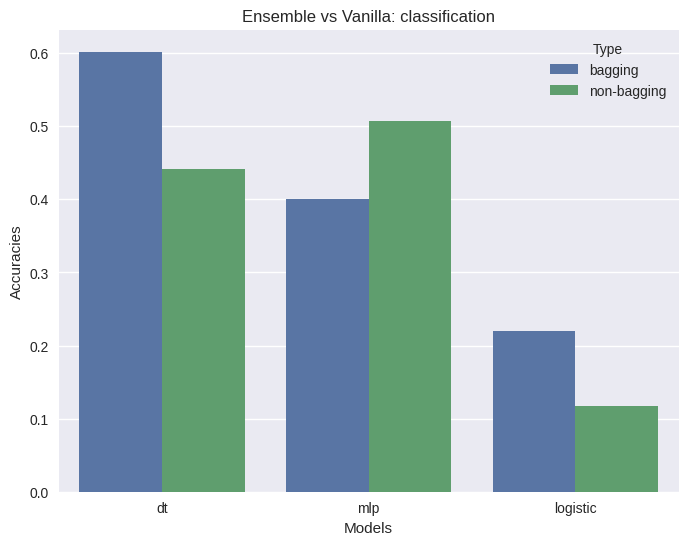

In [129]:
compare_models([dt, mlp, logistic], None, X_train_c, y_train_c, X_val_c, y_val_c, accuracy_fxn=accuracy_score, y_transform=np.argmax, name='classification',     
               list_1_names = ['dt', 'mlp', 'logistic'], bagging_accs = [0.602, 0.401, 0.22])

####  Regression

In [130]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv('./data/HousingData.csv')
nan_cols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'AGE', 'LSTAT']
for col in nan_cols:
    df[col] = df[col].fillna(df[col].mean(), inplace=False)
    

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled_data, columns=df.columns)


X_train, X_val, y_train, y_val = train_test_split(df_scaled.iloc[:, :-1].values, df_scaled.iloc[:, -1].values, test_size=0.1)
y_train, y_val = y_train.reshape(-1, 1), y_val.reshape(-1, 1)

X_train.shape, y_train.shape, X_val.shape, y_val.shape


((455, 13), (455, 1), (51, 13), (51, 1))

In [131]:

linear = Model(lr=5e-3, logger=None, loss_fxn=MSELoss(), type='regression', epochs=2000)
linear.add(Layer(13, 1, Linear()))

mlp = Model(lr=5e-3, logger=None, loss_fxn=MSELoss(), type='regression', epochs=1000)
mlp.add(Layer(13, 16, Tanh()))
mlp.add(Layer(16, 16, Relu()))
mlp.add(Layer(16, 1, Linear()))

dt = DecisionTree(criterion='absolute_error', max_depth=5, task='regression')


bag = Bagging(
    model_list=[linear, mlp, dt],
    X=X_train,
    y=y_train,
    frac=0.25,
    num_estimators=3,
    bootstrap=False,
    voting_mechanism='soft',
    task='regression'
)

bag

In [28]:
bag.train()

epoch: 1999 	Train:[loss:0.2495 acc:0.8021]]
epoch: 1999 	Train:[loss:0.2799 acc:0.7712]]
epoch: 1999 	Train:[loss:0.2022 acc:0.8094]]
epoch: 999 	Train:[loss:0.0968 acc:0.8988]]
epoch: 999 	Train:[loss:0.0917 acc:0.9089]]
epoch: 999 	Train:[loss:0.0679 acc:0.9160]]
Accuracy of decision tree: 0.9463029617036556
Accuracy of decision tree: 0.946631100918327
Accuracy of decision tree: 0.9840838162743353
Training done!
Model weights loaded


In [31]:
pred = bag(X_val)
r2_score(y_val, pred)



Prediction using soft vote


0.6675348374381118

In [134]:
best_regressors


,num_estimator,frac,voting,train_acc,val_acc,model,bootstrap
125,8,0.25,hard,0.840468,0.821622,<__main__.DecisionTree object at 0x7f950cae8520>,False
103,5,0.50,soft,0.666978,0.615613,Layer: [in:13] [out:16] [activation:Tanh]\nLay...,True
75,5,0.15,hard,0.706540,0.796165,Layer: [in:13] [out:1] [activation:Linear]\n,False


Accuracy of decision tree: 0.9083382963402538
epoch: 999 	Train:[loss:0.2210 acc:0.7886]]
epoch: 1999 	Train:[loss:0.2819 acc:0.7303]]


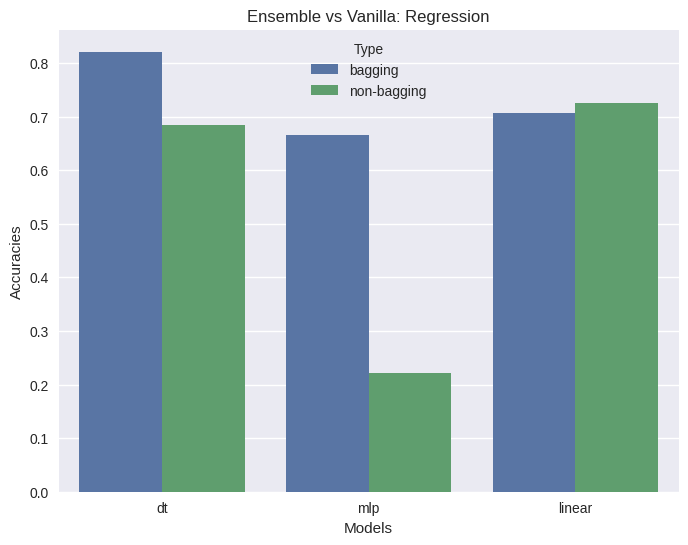

In [135]:
compare_models([dt, mlp, linear], None, X_train_r, y_train_r, X_val_r, y_val_r, accuracy_fxn=r2_score, y_transform=lambda x, y:x, name='Regression',
               bagging_accs=[0.821, 0.666, 0.706], list_1_names=['dt', 'mlp', 'linear'])